<a href="https://colab.research.google.com/github/SecrezS/MACDforecasting/blob/main/ANL488_pct_change_2Oct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import required libraries




In [ ]:
# Import required libraries

!pip install pycaret yellowbrick
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import seaborn as sns
import pycaret
from pycaret.regression import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import HuberRegressor
from sklearn.svm import SVR
from yellowbrick.regressor import PredictionError

# Download and extract the libta-lib binaries
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1

# Download and extract the Python wrapper for TA-Lib
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

# Import TA-Lib
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4071    0  4071    0     0    520      0 --:--:--  0:00:07 --:--:--  1135
100  517k  100  517k    0     0  65049      0  0:00:08  0:00:08 --:--:-- 65049
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4091    0  4091    0     0  11959      0 --:--:-- --:--:-- --:--:-- 11961
100  392k  100  392k    0     0   621k      0 --:--:-- --:--:-- --:--:--  621k


# Step 2: Download data and prepare main dataframe


In [ ]:
# Download data for multiple tickers (SPY, DIA, QQQ, IWM, XLK)
tickers = ["SPY", "DIA", "QQQ", "IWM", "XLK"]
dfs = {}

for ticker in tickers:
    # Download historical data
    df = yf.download(ticker, start="2012-01-01", end="2024-01-01")
    df.reset_index(inplace=True)
    dfs[ticker] = df

# Choose the main dataset for demonstration, SPY
data = dfs["SPY"].copy()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Step 3: Adding technical indicators using TA-Lib

In [ ]:
# Adding Technical Indicators using TA-Lib

# Calculate Relative Strength Index (RSI)
data['RSI'] = talib.RSI(data['Adj Close'], timeperiod=14)

# Calculate Moving Average Convergence Divergence (MACD)
data['MACD'], data['MACD_signal'], data['MACD_diff'] = talib.MACD(data['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)

# Calculate Average True Range (ATR)
data['ATR'] = talib.ATR(data['High'], data['Low'], data['Adj Close'], timeperiod=14)

# Calculate Bollinger Bands (BB)
data['bb_bbm'], data['bb_bbh'], data['bb_bbl'] = talib.BBANDS(data['Adj Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

# Calculate Keltner Channel (KC)
data['EMA_KC'] = talib.EMA(data['Adj Close'], timeperiod=20)
data['KC_upper'] = data['EMA_KC'] + (data['ATR'] * 1.5)
data['KC_lower'] = data['EMA_KC'] - (data['ATR'] * 1.5)
data['KC'] = (data['Adj Close'] - data['KC_upper']) / data['Adj Close']
data.drop(columns=['EMA_KC', 'KC_upper', 'KC_lower'], inplace=True)

# Calculate Donchian Channel (DC)
data['DC_upper'] = data['High'].rolling(window=20).max()
data['DC_lower'] = data['Low'].rolling(window=20).min()
data['DC_middle'] = (data['DC_upper'] + data['DC_lower']) / 2

# Calculate On-Balance Volume (OBV)
data['OBV'] = talib.OBV(data['Adj Close'], data['Volume'])

# Calculate Chaikin Money Flow (CMF)
cmf_period = 20
data['Money_Flow_Multiplier'] = ((data['Adj Close'] - data['Low']) - (data['High'] - data['Adj Close'])) / (data['High'] - data['Low'])
data['Money_Flow_Volume'] = data['Money_Flow_Multiplier'] * data['Volume']
data['CMF'] = data['Money_Flow_Volume'].rolling(window=cmf_period).sum() / data['Volume'].rolling(window=cmf_period).sum()

# Calculate the Stochastic Oscillator
data['stoch_k'], data['stoch_d'] = talib.STOCH(data['High'], data['Low'], data['Adj Close'],
                                               fastk_period=14,  # The %K period
                                               slowk_period=3,   # The %K slowing period
                                               slowk_matype=0,   # Moving average type for %K (0 = SMA)
                                               slowd_period=3,   # The %D period
                                               slowd_matype=0)   # Moving average type for %D (0 = SMA)

# Calculate the Average Directional Index (ADX)
data['ADX'] = talib.ADX(data['High'], data['Low'], data['Adj Close'], timeperiod=14)

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Step 4: Calculate the daily percentage change using the previous day's adjusted close


In [ ]:
data['Previous_Day_Adj_Close'] = data['Adj Close'].shift(1)  # Shifting to get the previous day's close
data['Daily_Percentage_Change'] = ((data['Adj Close'] - data['Previous_Day_Adj_Close']) / data['Previous_Day_Adj_Close']) * 100

In [ ]:
# Removing rows with NaN values (first row will have NaN due to the shift)
data.dropna(subset=['Daily_Percentage_Change'], inplace=True)

# Drop the unnecessary 'Previous_Day_Adj_Close' column
data.drop(columns=['Previous_Day_Adj_Close'], inplace=True)

# Step 5: Create lag features

In [ ]:
# List of features to create lag features (exlcude "Adj Close")
features_to_lag = ['Volume', 'RSI', 'MACD', 'MACD_signal',
                   'MACD_diff', 'ATR', 'bb_bbm', 'bb_bbh', 'bb_bbl', 'KC',
                   'DC_upper', 'DC_lower', 'DC_middle','OBV','CMF','stoch_k','stoch_d','ADX']

# Number of lag days to create
lag_days = 20

# Function to create lagged features
def create_lagged_features(df, lag_days, columns):
    for col in columns:
        for lag in range(1, lag_days + 1):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

# Apply lagged features
data = create_lagged_features(data, lag_days, features_to_lag)
data.dropna(inplace=True)

# Check the resulting DataFrame to confirm new columns
print(data.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2012-03-20  140.050003  140.610001  139.639999  140.440002  111.839790   
2012-03-21  140.520004  140.649994  139.919998  140.210007  111.656631   
2012-03-22  139.179993  139.550003  138.740005  139.199997  110.852264   
2012-03-23  139.320007  139.809998  138.550003  139.649994  111.210640   
2012-03-26  140.649994  141.610001  140.600006  141.610001  112.771500   

               Volume        RSI      MACD  MACD_signal  MACD_diff  ...  \
Date                                                                ...   
2012-03-20  121729700  71.356815  1.443676     1.252666   0.191009  ...   
2012-03-21  122388400  69.497178  1.432620     1.288657   0.143963  ...   
2012-03-22  135216700  61.871250  1.343466     1.299619   0.043847  ...   
2012-03-23  120521000  63.778304  1.286894     1.297074  -0.010180  ...   
2012-03-26  120164000  70.66109

In [ ]:
# Drop features that are not lagged
columns_to_drop = ['Open','High','Low','Close','Adj Close','Volume', 'RSI', 'MACD',
                   'MACD_signal', 'MACD_diff', 'ATR', 'bb_bbm', 'bb_bbh',
                   'bb_bbl', 'KC','DC_upper',
                   'DC_lower', 'DC_middle','OBV','CMF','Money_Flow_Multiplier',
                   'Money_Flow_Volume','stoch_k','stoch_d','ADX']

data.drop(columns=columns_to_drop, inplace=True)
data.fillna(method='ffill', inplace=True)

# Step 6: Split the data into train, validation, and test sets

In [ ]:
# Split into training, validation, and test sets
train_data = data[data.index < "2022-01-01"]
validation_data = data[(data.index >= "2022-01-01") & (data.index < "2023-01-01")]
test_data = data[data.index >= "2023-01-01"]

# Display the sizes of each set to ensure proper segregation
print(f"Training set: {train_data.shape}")
print(f"Validation set: {validation_data.shape}")
print(f"Test set: {test_data.shape}")

Training set: (2464, 361)
Validation set: (251, 361)
Test set: (250, 361)


# Step 7: Identify important features using RandomForest

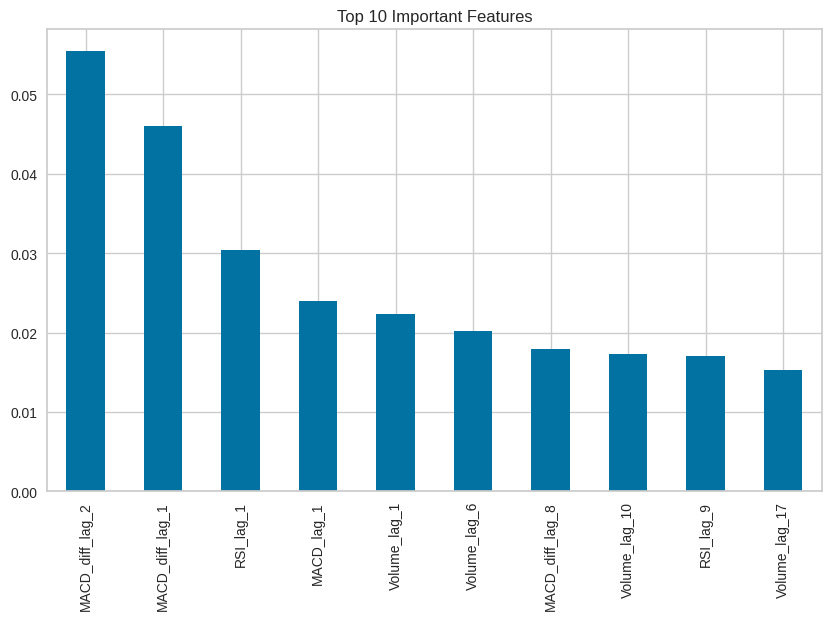

['MACD_diff_lag_2',
 'MACD_diff_lag_1',
 'RSI_lag_1',
 'MACD_lag_1',
 'Volume_lag_1',
 'Volume_lag_6',
 'MACD_diff_lag_8',
 'Volume_lag_10',
 'RSI_lag_9',
 'Volume_lag_17',
 'RSI_lag_2',
 'MACD_diff_lag_6',
 'MACD_diff_lag_7',
 'MACD_diff_lag_3',
 'Volume_lag_9',
 'Volume_lag_3',
 'Volume_lag_2',
 'MACD_diff_lag_9',
 'RSI_lag_3']

In [ ]:
X_train = train_data.drop(columns=['Daily_Percentage_Change'])
y_train = train_data['Daily_Percentage_Change']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Identify important features (features with importance > 0.01, contributes at least 1% to the model's predictive ability)
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
selected_features = feature_importances[feature_importances > 0.01].index.tolist()

# Plot the top 10 important features
plt.figure(figsize=(10, 6))
feature_importances.head(10).plot(kind='bar')
plt.title('Top 10 Important Features')
plt.show()

# Show the selected features
selected_features

In [ ]:
# Use only the selected features
train_data_selected = train_data[selected_features + ['Daily_Percentage_Change']]
validation_data_selected = validation_data[selected_features + ['Daily_Percentage_Change']]
test_data_selected = test_data[selected_features + ['Daily_Percentage_Change']]

# Step 8: Setup regression model using PyCaret

In [ ]:
# Setup regression model using PyCaret for predicting returns
regression_setup = setup(
    data=train_data_selected,
    target='Daily_Percentage_Change',
    fold_strategy='timeseries',  # Time series cross-validation
    fold=5,                      # Use 5 folds for cross-validation
    session_id=42,
    use_gpu=False,
    data_split_shuffle=False,    # Ensure data is not shuffled
    fold_shuffle=False           # Ensure folds are not shuffled
)

,Description,Value
0,Session id,42
1,Target,Daily_Percentage_Change
2,Target type,Regression
3,Original data shape,"(2464, 20)"
4,Transformed data shape,"(2464, 20)"
5,Transformed train set shape,"(1724, 20)"
6,Transformed test set shape,"(740, 20)"
7,Numeric features,19
8,Preprocess,True
9,Imputation type,simple


# Step 9: Compare models and select the top 3

In [ ]:
# Compare different models
best_model = compare_models(n_select=3, sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dummy,Dummy Regressor,0.5696,0.6756,0.7936,-0.0032,0.4544,1.2140,0.0280
omp,Orthogonal Matching Pursuit,0.5726,0.6771,0.7954,-0.0119,0.4529,1.2322,0.0600
huber,Huber Regressor,0.5716,0.6800,0.7961,-0.0088,0.4345,1.3546,0.0380
lasso,Lasso Regression,0.5744,0.6826,0.7993,-0.0239,0.4368,1.3403,0.0300
en,Elastic Net,0.5744,0.6826,0.7993,-0.0239,0.4368,1.3403,0.0360
llar,Lasso Least Angle Regression,0.5744,0.6826,0.7993,-0.0239,0.4368,1.3403,0.0300
lr,Linear Regression,0.5740,0.6837,0.7996,-0.0229,0.4269,1.3666,1.7360
ridge,Ridge Regression,0.5875,0.7064,0.8130,-0.0585,0.4043,1.7914,0.0360
ada,AdaBoost Regressor,0.6023,0.7286,0.8287,-0.1165,0.4081,1.9796,0.2060
et,Extra Trees Regressor,0.6114,0.7638,0.8481,-0.1623,0.3763,2.4071,0.5840


Processing:   0%|          | 0/83 [00:00<?, ?it/s]

# Step 10: Evaluate models using the validation set







In [ ]:
# Evaluate the models on the validation set
validation_X = validation_data_selected.drop(columns=['Daily_Percentage_Change'])
validation_y = validation_data_selected['Daily_Percentage_Change']

evaluated_models = []
for model in best_model:
    # Evaluate the model directly on validation data without finalizing
    validation_predictions = predict_model(model, data=validation_X)
    val_rmse = np.sqrt(mean_squared_error(validation_y, validation_predictions['prediction_label']))
    val_r2 = r2_score(validation_y, validation_predictions['prediction_label'])

    print(f"Initial Validation RMSE for model {model}: {val_rmse}")
    print(f"Initial Validation R² Score for model {model}: {val_r2}")

    evaluated_models.append((model, val_rmse, val_r2))

# Select the best model(s) based on the lowest RMSE
evaluated_models.sort(key=lambda x: x[1])  # Sort by RMSE in ascending order
top_models = [model[0] for model in evaluated_models[:3]]  # Select top 3 models based on RMSE

Initial Validation RMSE for model DummyRegressor(): 1.5285553887045082
Initial Validation R² Score for model DummyRegressor(): -0.005831697459930396


Initial Validation RMSE for model OrthogonalMatchingPursuit(): 1.5284819639459484
Initial Validation R² Score for model OrthogonalMatchingPursuit(): -0.005735068739367355


Initial Validation RMSE for model HuberRegressor(): 1.5331596611883505
Initial Validation R² Score for model HuberRegressor(): -0.01190030068257597


In [ ]:
# Filter out DummyRegressor from top models
top_models = [model for model in top_models if model.__class__.__name__ != 'DummyRegressor']

# Check if there are models left to tune
if not top_models:
    print("No models left to tune after removing DummyRegressor. Please select more advanced models.")
else:
    # Fine-tune the remaining models
    tuned_models = [tune_model(model, optimize='RMSE', fold=5) for model in top_models]


# Fine-tune the selected models using PyCaret's tune_model
tuned_models = [tune_model(model, optimize='RMSE', fold=5) for model in top_models]  # Tune top models

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5191,0.4632,0.6806,-0.0141,0.3980,1.3750
1,0.5916,0.6706,0.8189,-0.0146,0.4475,1.1907
2,0.7037,0.9404,0.9697,0.0083,0.5302,1.4853
3,0.3225,0.2054,0.4532,-0.0097,0.3046,1.1295
4,0.7200,1.1098,1.0535,-0.0090,0.5420,1.1217
Mean,0.5714,0.6779,0.7952,-0.0078,0.4445,1.2604
Std,0.1447,0.3240,0.2135,0.0083,0.0879,0.1449


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5219,0.4628,0.6803,-0.0131,0.3983,1.4426
1,0.5932,0.6785,0.8237,-0.0266,0.4366,1.2365
2,0.7005,0.9439,0.9715,0.0046,0.5094,1.5759
3,0.3203,0.2017,0.4491,0.0083,0.2945,1.3477
4,0.7201,1.1104,1.0537,-0.0094,0.5239,1.2322
Mean,0.5712,0.6794,0.7957,-0.0072,0.4326,1.3670
Std,0.1448,0.3258,0.2153,0.0126,0.0831,0.1303


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5191,0.4632,0.6806,-0.0141,0.3980,1.3750
1,0.5916,0.6706,0.8189,-0.0146,0.4475,1.1907
2,0.7037,0.9404,0.9697,0.0083,0.5302,1.4853
3,0.3225,0.2054,0.4532,-0.0097,0.3046,1.1295
4,0.7200,1.1098,1.0535,-0.0090,0.5420,1.1217
Mean,0.5714,0.6779,0.7952,-0.0078,0.4445,1.2604
Std,0.1447,0.3240,0.2135,0.0083,0.0879,0.1449


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5219,0.4628,0.6803,-0.0131,0.3983,1.4426
1,0.5932,0.6785,0.8237,-0.0266,0.4366,1.2365
2,0.7005,0.9439,0.9715,0.0046,0.5094,1.5759
3,0.3203,0.2017,0.4491,0.0083,0.2945,1.3477
4,0.7201,1.1104,1.0537,-0.0094,0.5239,1.2322
Mean,0.5712,0.6794,0.7957,-0.0072,0.4326,1.3670
Std,0.1448,0.3258,0.2153,0.0126,0.0831,0.1303


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
# Finalize each of the tuned models
final_models = [finalize_model(model) for model in tuned_models]

#Step 11: Test the models and generate error plots

Testing Model 1: Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['MACD_diff_lag_2',
                                             'MACD_diff_lag_1', 'RSI_lag_1',
                                             'MACD_lag_1', 'Volume_lag_1',
                                             'Volume_lag_6', 'MACD_diff_lag_8',
                                             'Volume_lag_10', 'RSI_lag_9',
                                             'Volume_lag_17', 'RSI_lag_2',
                                             'MACD_diff_lag_6',
                                             'MACD_diff_lag_7',
                                             'MACD_diff_lag_3', 'Volume_lag_9',
                                             'Volume_lag_3', 'Volume_lag_2',
                                             'MACD_diff_lag_9', 'RSI_lag_3'],
                                    transformer=SimpleImputer())),
                ('categorical_

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.6494,0.6812,0.8253,-0.0081,0.4993,1.1734


Model 1 - Test RMSE: 0.8253489295411951, Test R² Score: -0.008082750269330141
Testing Model 2: Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['MACD_diff_lag_2',
                                             'MACD_diff_lag_1', 'RSI_lag_1',
                                             'MACD_lag_1', 'Volume_lag_1',
                                             'Volume_lag_6', 'MACD_diff_lag_8',
                                             'Volume_lag_10', 'RSI_lag_9',
                                             'Volume_lag_17', 'RSI_lag_2',
                                             'MACD_diff_lag_6',
                                             'MACD_diff_lag_7',
                                             'MACD_diff_lag_3', 'Volume_lag_9',
                                             'Volume_lag_3', 'Volume_lag_2',
                                             'MACD_diff_lag_9', 'RSI_lag_3'],
                   

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.6427,0.6751,0.8216,0.0009,0.4829,1.1294


Model 2 - Test RMSE: 0.8216493442369442, Test R² Score: 0.0009343560069559054


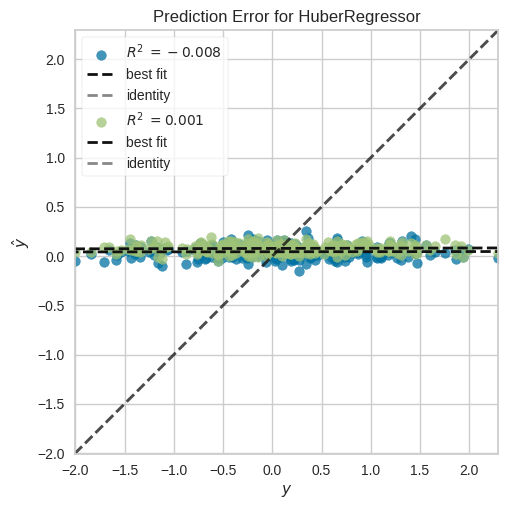

In [ ]:
# Evaluate the finalized models on the test set
for i, model in enumerate(final_models, start=1):
    print(f"Testing Model {i}: {model}")

    # Make predictions on the test set
    predictions = predict_model(model, data=test_data_selected)

    # Calculate RMSE and R² score on the test set
    rmse = np.sqrt(mean_squared_error(test_data_selected['Daily_Percentage_Change'], predictions['prediction_label']))
    r2 = r2_score(test_data_selected['Daily_Percentage_Change'], predictions['prediction_label'])
    print(f"Model {i} - Test RMSE: {rmse}, Test R² Score: {r2}")

    # Plot the prediction error using Yellowbrick
    visualizer = PredictionError(model)
    visualizer.score(test_data_selected[selected_features], test_data_selected['Daily_Percentage_Change'])
    visualizer.show(outpath=f'prediction_error_model_{i}.png')  # Save the plot as a PNG file